In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import numpy as np
import torchinfo
import requests
from torch.utils.data import Dataset, DataLoader

In [6]:
#10
# Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''

# Preparing the dataset for sequence prediction
max_length = 10  # Maximum length of input sequences
sequences = [text[i:i + max_length] for i in range(len(text) - max_length)]
labels = [text[i + max_length] for i in range(len(text) - max_length)]

# Creating character vocabulary
chars = sorted(list(set(text)))
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Convert sequences and labels to tensors
X = torch.tensor([[char_to_ix[ch] for ch in seq] for seq in sequences], dtype=torch.long)
y = torch.tensor([char_to_ix[label] for label in labels], dtype=torch.long)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get output of last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 3
nhead = 2
learning_rate = 0.001
epochs = 50

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary = torchinfo.summary(model, input_data=X_train)
print(summary)

# Training the model
total_start_time = time.time()
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    if (epoch+1) % 5 == 0:
        end_time = time.time()
        execution_time = end_time - start_time
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}, Execution Time: {execution_time} seconds')

total_end_time = time.time()
total_execution_time = total_end_time - total_start_time
print(f'Total Execution Time: {total_execution_time} seconds')

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
CharTransformer                               [1900, 44]                --
├─Embedding: 1-1                              [1900, 10, 128]           5,632
├─TransformerEncoder: 1-2                     [1900, 10, 128]           --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1900, 10, 128]           593,024
│    │    └─TransformerEncoderLayer: 3-2      [1900, 10, 128]           593,024
│    │    └─TransformerEncoderLayer: 3-3      [1900, 10, 128]           593,024
├─Linear: 1-3                                 [1900, 44]                5,676
Total params: 1,790,380
Trainable params: 1,790,380
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.03
Input size (MB): 0.15
Forward/backward pass size (MB): 1129.12
Params size (MB): 6.37
Estimated Total Size (MB): 1135.64
Epoch 5, Loss: 2.8119800090789795, Validation Loss: 2.67365527

Using device: cuda
Vocabulary size: 42
Training with sequence length: 10, hidden size: 128, layers: 2

--- Initializing Simple RNN (No Attention) ---
--- Initializing Encoder-Decoder RNN with Attention ---

Simple RNN parameters: 274,986
Attention RNN parameters: 648,490
Parameter ratio: 2.36x

--- Training Simple RNN (No Attention) ---
Epoch 1/50, Loss: 3.5073, Accuracy: 0.0945, Time: 0.07s
Epoch 2/50, Loss: 3.0489, Accuracy: 0.1467, Time: 0.03s
Epoch 3/50, Loss: 2.9639, Accuracy: 0.1839, Time: 0.03s
Epoch 4/50, Loss: 2.8612, Accuracy: 0.2070, Time: 0.04s
Epoch 5/50, Loss: 2.7381, Accuracy: 0.2482, Time: 0.04s
Epoch 6/50, Loss: 2.5990, Accuracy: 0.2915, Time: 0.04s
Epoch 7/50, Loss: 2.4723, Accuracy: 0.3106, Time: 0.04s
Epoch 8/50, Loss: 2.3565, Accuracy: 0.3337, Time: 0.04s
Epoch 9/50, Loss: 2.2303, Accuracy: 0.3859, Time: 0.04s
Epoch 10/50, Loss: 2.1265, Accuracy: 0.4161, Time: 0.03s
Epoch 11/50, Loss: 2.0405, Accuracy: 0.4442, Time: 0.03s
Epoch 12/50, Loss: 1.9512, Accuracy: 0.4714

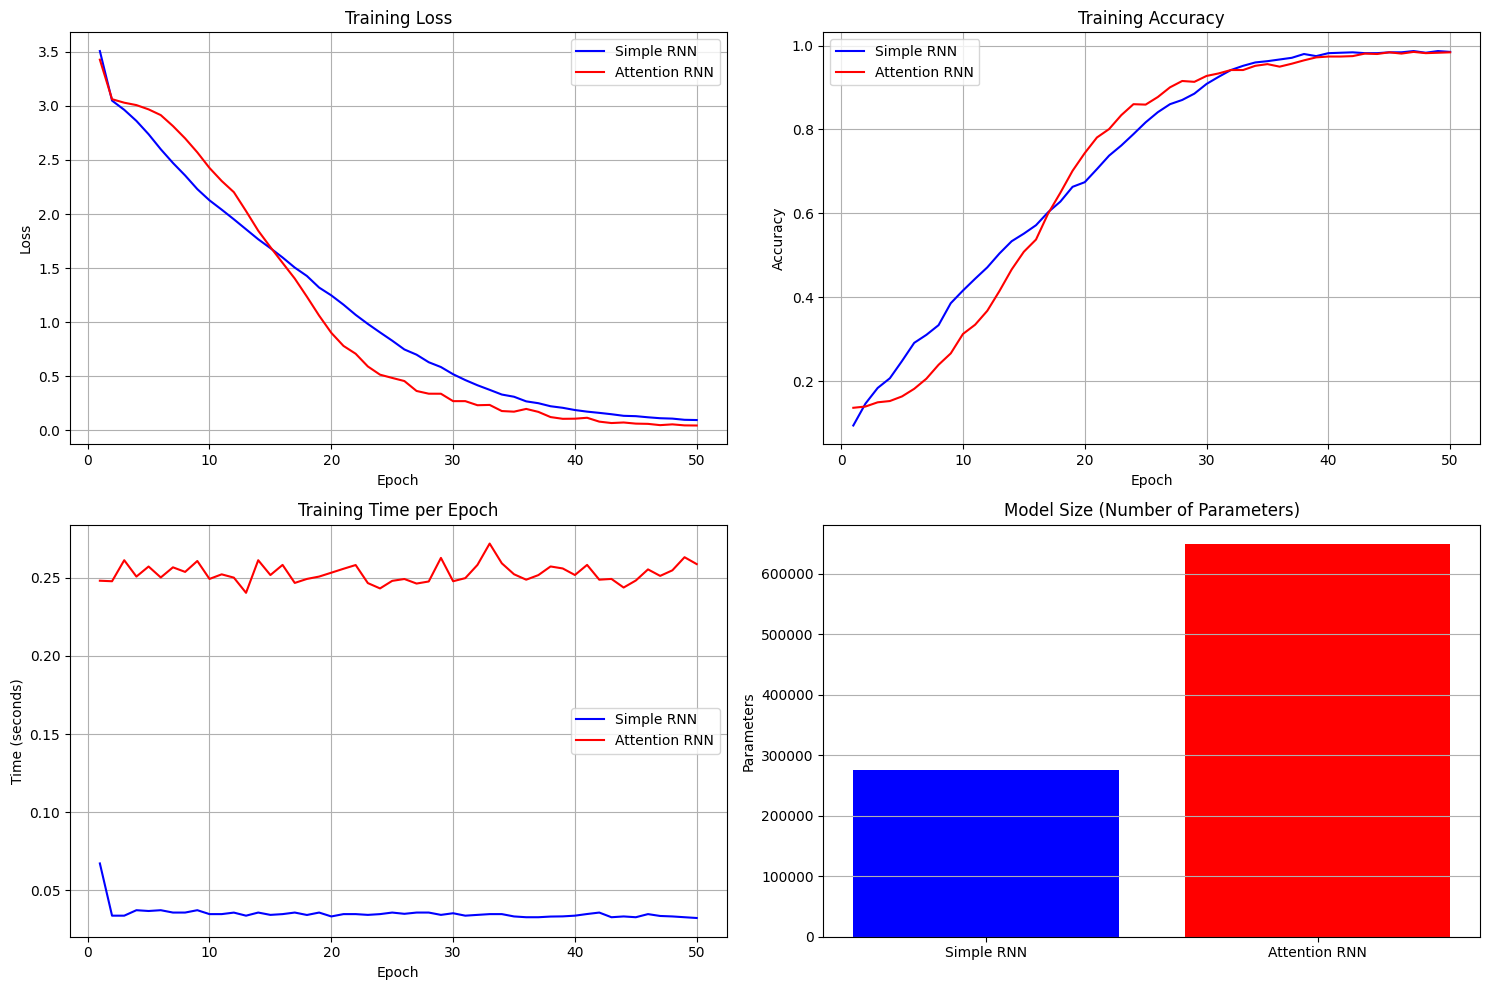


--- Model Comparison Summary ---
Model                Train Loss   Val Loss     Val Acc      Avg Time/Epoch  Parameters  
---------------------------------------------------------------------------
Simple RNN           0.0943       3.1501       0.3655       0.04           s 274,986     
Attention RNN        0.0438       5.2423       0.2731       0.25           s 648,490     


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Sample text for next character prediction
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.'''

# RNN without Attention
class RNNEncoderWithoutAttention(nn.Module):
    """Simple RNN encoder without attention mechanism"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1, rnn_type='LSTM'):
        super(RNNEncoderWithoutAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # RNN layer
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # default to LSTM
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Output projection
        self.fc = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, hidden_size]
        
        # Pass through RNN
        output, hidden = self.rnn(embedded)  # output: [batch_size, seq_len, hidden_size]
        
        # Use only the last time step for prediction
        output = self.fc(output[:, -1, :])  # [batch_size, input_size]
        
        return output

# Attention mechanism
class Attention(nn.Module):
    """Attention mechanism to be used in the decoder"""
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        
        # Attention layers
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden shape: [batch_size, hidden_size]
        # encoder_outputs shape: [batch_size, seq_len, hidden_size]
        
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)
        
        # Repeat hidden state seq_len times
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # [batch_size, seq_len, hidden_size]
        
        # Concatenate hidden and encoder_outputs
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, seq_len, hidden_size]
        
        # Get attention weights
        attention = self.v(energy).squeeze(2)  # [batch_size, seq_len]
        attention_weights = torch.softmax(attention, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
        
        # Apply attention weights to encoder outputs
        context = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, hidden_size]
        context = context.squeeze(1)  # [batch_size, hidden_size]
        
        return context, attention_weights

# RNN Decoder with Attention
class RNNDecoderWithAttention(nn.Module):
    """RNN decoder with attention mechanism"""
    def __init__(self, output_size, hidden_size, num_layers=1, dropout=0.1, rnn_type='LSTM'):
        super(RNNDecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # Attention mechanism
        self.attention = Attention(hidden_size)
        
        # RNN layer
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size * 2, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # default to LSTM
            self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Output projection
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        # input shape: [batch_size]
        # hidden shape: tuple of [num_layers, batch_size, hidden_size] or single tensor for GRU
        # encoder_outputs shape: [batch_size, seq_len, hidden_size]
        
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.embedding(input)  # [batch_size, 1, hidden_size]
        
        # If LSTM, get just the hidden state, not the cell state
        if self.rnn_type == 'LSTM':
            decoder_hidden = hidden[0][-1].unsqueeze(0)  # [1, batch_size, hidden_size]
        else:
            decoder_hidden = hidden[-1].unsqueeze(0)  # [1, batch_size, hidden_size]
        
        # Calculate attention
        context, attention_weights = self.attention(decoder_hidden.squeeze(0), encoder_outputs)
        
        # Concatenate context and embedding
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
        
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Concatenate output and context
        output = torch.cat((output.squeeze(1), context), dim=1)
        
        # Pass through linear layer
        output = self.fc(output)
        
        return output, hidden, attention_weights

# Full Encoder-Decoder RNN with Attention
class EncoderDecoderRNN(nn.Module):
    """Full encoder-decoder model with cross-attention"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1, rnn_type='LSTM'):
        super(EncoderDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.input_size = input_size
        
        # Encoder
        self.encoder_embedding = nn.Embedding(input_size, hidden_size)
        if rnn_type == 'LSTM':
            self.encoder_rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        else:  # GRU
            self.encoder_rnn = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        
        # Decoder with attention
        self.decoder = RNNDecoderWithAttention(input_size, hidden_size, num_layers, dropout, rnn_type)
    
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        """
        Forward pass of the encoder-decoder model
        Args:
            src: Source sequence [batch_size, src_len]
            trg: Target sequence [batch_size, trg_len], optional for inference
            teacher_forcing_ratio: Probability of using teacher forcing
        """
        batch_size = src.shape[0]
        src_len = src.shape[1]
        trg_vocab_size = self.input_size
        
        # If target not provided (inference), use source length + 1 for maximum generation length
        if trg is None:
            max_len = src_len + 10  # Allow generation of a few more tokens than input
            trg = torch.zeros((batch_size, 1), device=src.device, dtype=torch.long)
        else:
            max_len = trg.shape[1]
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, trg_vocab_size).to(src.device)
        
        # Encode the source sequence
        embedded = self.encoder_embedding(src)
        encoder_outputs, hidden = self.encoder_rnn(embedded)
        
        # First input to the decoder is the SOS token (assuming the first token of target is SOS)
        if trg is not None:
            input = trg[:, 0]
        else:
            # For inference, use a fixed SOS token (assumed to be 1 here)
            input = torch.ones(batch_size, dtype=torch.long, device=src.device)
        
        for t in range(1, max_len):
            # Pass through decoder with attention
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            
            # Save output (excluding first token which should be SOS)
            outputs[:, t, :] = output
            
            # Decide next input: teacher forcing or highest probability prediction
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            
            if teacher_force and trg is not None:
                input = trg[:, t] if t < trg.shape[1] else 0  # Use ground truth
            else:
                # Get the highest predicted token
                top1 = output.argmax(1)
                input = top1
        
        return outputs

# Character dataset for next character prediction
class CharDataset(Dataset):
    """Dataset for character-level sequence prediction"""
    def __init__(self, text, seq_length):
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)
        
        # Create sequences and labels
        self.sequences = []
        self.next_chars = []
        
        for i in range(len(text) - seq_length):
            self.sequences.append(text[i:i + seq_length])
            self.next_chars.append(text[i + seq_length])
        
        # Convert to indices
        self.sequence_indices = [[self.char_to_idx[char] for char in seq] for seq in self.sequences]
        self.next_char_indices = [self.char_to_idx[char] for char in self.next_chars]
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq_indices = torch.tensor(self.sequence_indices[idx], dtype=torch.long)
        target_char = torch.tensor(self.next_char_indices[idx], dtype=torch.long)
        
        # For the attention model, also provide target sequences for teacher forcing
        target_seq = torch.cat([seq_indices, target_char.unsqueeze(0)], dim=0)
        return seq_indices, target_seq, target_char
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def decode(self, indices):
        return ''.join([self.idx_to_char[idx.item()] for idx in indices])

# Function to train the simple RNN model
def train_simple_rnn(model, dataloader, criterion, optimizer, device, epochs=10):
    """Train the simple RNN model without attention"""
    model.train()
    results = {
        'train_loss': [],
        'train_acc': [],
        'epochs': [],
        'time_per_epoch': []
    }
    
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for x, _, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_loss += loss.item() * x.size(0)
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y).sum().item()
            total_predictions += y.size(0)
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(dataloader.dataset)
        accuracy = correct_predictions / total_predictions
        epoch_time = time.time() - start_time
        
        # Store results
        results['train_loss'].append(avg_loss)
        results['train_acc'].append(accuracy)
        results['epochs'].append(epoch + 1)
        results['time_per_epoch'].append(epoch_time)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
    
    return results

# Function to train the encoder-decoder RNN with attention
def train_attention_rnn(model, dataloader, criterion, optimizer, device, epochs=10):
    """Train the encoder-decoder RNN model with attention"""
    model.train()
    results = {
        'train_loss': [],
        'train_acc': [],
        'epochs': [],
        'time_per_epoch': []
    }
    
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for x, target_seq, y in dataloader:
            x, target_seq, y = x.to(device), target_seq.to(device), y.to(device)
            
            # Forward pass using teacher forcing
            optimizer.zero_grad()
            output = model(x, target_seq, teacher_forcing_ratio=0.5)
            
            # We are interested in predicting the next character (last position in the sequence)
            output = output[:, 1:, :]  # Remove first position (SOS token)
            output = output[:, -1, :]  # Take the last position's prediction
            
            loss = criterion(output, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_loss += loss.item() * x.size(0)
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y).sum().item()
            total_predictions += y.size(0)
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(dataloader.dataset)
        accuracy = correct_predictions / total_predictions
        epoch_time = time.time() - start_time
        
        # Store results
        results['train_loss'].append(avg_loss)
        results['train_acc'].append(accuracy)
        results['epochs'].append(epoch + 1)
        results['time_per_epoch'].append(epoch_time)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
    
    return results

# Function to evaluate models
def evaluate_model(model, dataloader, criterion, device, is_attention_model=False):
    """Evaluate either model type on the validation set"""
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for x, target_seq, y in dataloader:
            x, target_seq, y = x.to(device), target_seq.to(device), y.to(device)
            
            if is_attention_model:
                # Forward pass for attention model
                output = model(x, target_seq, teacher_forcing_ratio=0)  # No teacher forcing during evaluation
                output = output[:, 1:, :]  # Remove first position
                output = output[:, -1, :]  # Take the last position's prediction
            else:
                # Forward pass for simple model
                output = model(x)
            
            # Calculate loss
            loss = criterion(output, y)
            val_loss += loss.item() * x.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == y).sum().item()
            total_predictions += y.size(0)
    
    # Calculate metrics
    avg_loss = val_loss / len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# Function to count model parameters
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Set up the experiment
def run_experiment(seq_length=10, hidden_size=128, num_layers=2, rnn_type='LSTM', 
                   batch_size=64, learning_rate=0.001, epochs=10):
    """Run the experiment comparing RNN with and without attention"""
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataset
    dataset = CharDataset(text, seq_length)
    vocab_size = dataset.get_vocab_size()
    print(f"Vocabulary size: {vocab_size}")
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    print(f"Training with sequence length: {seq_length}, hidden size: {hidden_size}, layers: {num_layers}")
    
    # Initialize models
    print("\n--- Initializing Simple RNN (No Attention) ---")
    simple_rnn = RNNEncoderWithoutAttention(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        rnn_type=rnn_type
    ).to(device)
    
    print("--- Initializing Encoder-Decoder RNN with Attention ---")
    attention_rnn = EncoderDecoderRNN(
        input_size=vocab_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        rnn_type=rnn_type
    ).to(device)
    
    # Count parameters
    simple_params = count_parameters(simple_rnn)
    attention_params = count_parameters(attention_rnn)
    print(f"\nSimple RNN parameters: {simple_params:,}")
    print(f"Attention RNN parameters: {attention_params:,}")
    print(f"Parameter ratio: {attention_params/simple_params:.2f}x")
    
    # Initialize optimizers and criterion
    simple_optimizer = torch.optim.Adam(simple_rnn.parameters(), lr=learning_rate)
    attention_optimizer = torch.optim.Adam(attention_rnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Train models
    print("\n--- Training Simple RNN (No Attention) ---")
    simple_results = train_simple_rnn(simple_rnn, train_loader, criterion, simple_optimizer, device, epochs)
    
    print("\n--- Training Encoder-Decoder RNN with Attention ---")
    attention_results = train_attention_rnn(attention_rnn, train_loader, criterion, attention_optimizer, device, epochs)
    
    # Evaluate models
    print("\n--- Evaluating Models ---")
    simple_val_loss, simple_val_acc = evaluate_model(simple_rnn, val_loader, criterion, device, is_attention_model=False)
    attention_val_loss, attention_val_acc = evaluate_model(attention_rnn, val_loader, criterion, device, is_attention_model=True)
    
    print(f"\nSimple RNN - Val Loss: {simple_val_loss:.4f}, Val Accuracy: {simple_val_acc:.4f}")
    print(f"Attention RNN - Val Loss: {attention_val_loss:.4f}, Val Accuracy: {attention_val_acc:.4f}")
    
    # Calculate average training time
    simple_avg_time = sum(simple_results['time_per_epoch']) / epochs
    attention_avg_time = sum(attention_results['time_per_epoch']) / epochs
    
    # Add validation results to results dictionary
    simple_results['val_loss'] = simple_val_loss
    simple_results['val_acc'] = simple_val_acc
    attention_results['val_loss'] = attention_val_loss
    attention_results['val_acc'] = attention_val_acc
    
    # Create comparison visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    plt.plot(simple_results['epochs'], simple_results['train_loss'], 'b-', label='Simple RNN')
    plt.plot(attention_results['epochs'], attention_results['train_loss'], 'r-', label='Attention RNN')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training accuracy
    plt.subplot(2, 2, 2)
    plt.plot(simple_results['epochs'], simple_results['train_acc'], 'b-', label='Simple RNN')
    plt.plot(attention_results['epochs'], attention_results['train_acc'], 'r-', label='Attention RNN')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot training time per epoch
    plt.subplot(2, 2, 3)
    plt.plot(simple_results['epochs'], simple_results['time_per_epoch'], 'b-', label='Simple RNN')
    plt.plot(attention_results['epochs'], attention_results['time_per_epoch'], 'r-', label='Attention RNN')
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    
    # Plot model size comparison
    plt.subplot(2, 2, 4)
    models = ['Simple RNN', 'Attention RNN']
    params = [simple_params, attention_params]
    plt.bar(models, params, color=['blue', 'red'])
    plt.title('Model Size (Number of Parameters)')
    plt.ylabel('Parameters')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n--- Model Comparison Summary ---")
    print(f"{'Model':<20} {'Train Loss':<12} {'Val Loss':<12} {'Val Acc':<12} {'Avg Time/Epoch':<15} {'Parameters':<12}")
    print(f"{'-'*75}")
    print(f"{'Simple RNN':<20} {simple_results['train_loss'][-1]:<12.4f} {simple_val_loss:<12.4f} {simple_val_acc:<12.4f} {simple_avg_time:<15.2f}s {simple_params:<12,}")
    print(f"{'Attention RNN':<20} {attention_results['train_loss'][-1]:<12.4f} {attention_val_loss:<12.4f} {attention_val_acc:<12.4f} {attention_avg_time:<15.2f}s {attention_params:<12,}")
    
    return {
        'simple_rnn': {
            'model': simple_rnn,
            'results': simple_results,
            'val_loss': simple_val_loss,
            'val_acc': simple_val_acc,
            'params': simple_params,
            'avg_time': simple_avg_time
        },
        'attention_rnn': {
            'model': attention_rnn,
            'results': attention_results,
            'val_loss': attention_val_loss,
            'val_acc': attention_val_acc,
            'params': attention_params,
            'avg_time': attention_avg_time
        }
    }

# Run the experiment with default parameters
# You can modify these parameters as needed
results = run_experiment(
    seq_length=10,        # Length of input sequence
    hidden_size=128,      # Size of hidden layers
    num_layers=2,         # Number of RNN layers
    rnn_type='LSTM',      # 'LSTM' or 'GRU'
    batch_size=64,        # Batch size for training
    learning_rate=0.001,  # Learning rate
    epochs=50            # Number of training epochs
)

In [7]:
#20
# Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''

# Preparing the dataset for sequence prediction
max_length = 20  # Maximum length of input sequences
sequences = [text[i:i + max_length] for i in range(len(text) - max_length)]
labels = [text[i + max_length] for i in range(len(text) - max_length)]

# Creating character vocabulary
chars = sorted(list(set(text)))
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Convert sequences and labels to tensors
X = torch.tensor([[char_to_ix[ch] for ch in seq] for seq in sequences], dtype=torch.long)
y = torch.tensor([char_to_ix[label] for label in labels], dtype=torch.long)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get output of last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 3
nhead = 2
learning_rate = 0.001
epochs = 50

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary = torchinfo.summary(model, input_data=X_train)
print(summary)

# Training the model
total_start_time = time.time()
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    if (epoch+1) % 5 == 0:
        end_time = time.time()
        execution_time = end_time - start_time
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}, Execution Time: {execution_time} seconds')

total_end_time = time.time()
total_execution_time = total_end_time - total_start_time
print(f'Total Execution Time: {total_execution_time} seconds')

Layer (type:depth-idx)                        Output Shape              Param #
CharTransformer                               [1892, 44]                --
├─Embedding: 1-1                              [1892, 20, 128]           5,632
├─TransformerEncoder: 1-2                     [1892, 20, 128]           --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1892, 20, 128]           593,024
│    │    └─TransformerEncoderLayer: 3-2      [1892, 20, 128]           593,024
│    │    └─TransformerEncoderLayer: 3-3      [1892, 20, 128]           593,024
├─Linear: 1-3                                 [1892, 44]                5,676
Total params: 1,790,380
Trainable params: 1,790,380
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.01
Input size (MB): 0.30
Forward/backward pass size (MB): 2248.06
Params size (MB): 6.37
Estimated Total Size (MB): 2254.73
Epoch 5, Loss: 2.8013739585876465, Validation Loss: 2.68883204

In [8]:
#30
# Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''

# Preparing the dataset for sequence prediction
max_length = 30  # Maximum length of input sequences
sequences = [text[i:i + max_length] for i in range(len(text) - max_length)]
labels = [text[i + max_length] for i in range(len(text) - max_length)]

# Creating character vocabulary
chars = sorted(list(set(text)))
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Convert sequences and labels to tensors
X = torch.tensor([[char_to_ix[ch] for ch in seq] for seq in sequences], dtype=torch.long)
y = torch.tensor([char_to_ix[label] for label in labels], dtype=torch.long)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get output of last Transformer block
        return output

# Hyperparameters
hidden_size = 128
num_layers = 2
nhead = 2
learning_rate = 0.001
epochs = 50

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary = torchinfo.summary(model, input_data=X_train)
print(summary)

# Training the model
total_start_time = time.time()
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    if (epoch+1) % 5 == 0:
        end_time = time.time()
        execution_time = end_time - start_time
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}, Execution Time: {execution_time} seconds')

total_end_time = time.time()
total_execution_time = total_end_time - total_start_time
print(f'Total Execution Time: {total_execution_time} seconds')

Layer (type:depth-idx)                        Output Shape              Param #
CharTransformer                               [1884, 44]                --
├─Embedding: 1-1                              [1884, 30, 128]           5,632
├─TransformerEncoder: 1-2                     [1884, 30, 128]           --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1884, 30, 128]           593,024
│    │    └─TransformerEncoderLayer: 3-2      [1884, 30, 128]           593,024
├─Linear: 1-3                                 [1884, 44]                5,676
Total params: 1,197,356
Trainable params: 1,197,356
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.01
Input size (MB): 0.45
Forward/backward pass size (MB): 2257.85
Params size (MB): 4.26
Estimated Total Size (MB): 2262.56
Epoch 5, Loss: 2.7686641216278076, Validation Loss: 2.723860502243042, Validation Accuracy: 0.24152542650699615, Execution Time: 2.62168359756

Problem 2

In [9]:
#20
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 2
num_heads = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.5118835386903635, Validation Loss: 2.4830023194467503, Validation Accuracy: 0.2692045617558457
Epoch 2, Train Loss: 2.483218213335682, Validation Loss: 2.474422101601007, Validation Accuracy: 0.2627178668770621
Epoch 3, Train Loss: 2.477689945480605, Validation Loss: 2.4711267710450286, Validation Accuracy: 0.268657653134414
Epoch 4, Train Loss: 2.474779497583565, Validation Loss: 2.4696085486550907, Validation Accuracy: 0.2636413355329221
Epoch 5, Train Loss: 2.472595908313139, Validation Loss: 2.4671463198888217, Validation Accuracy: 0.268021087361928
Epoch 6, Train Loss: 2.471303691755937, Validation Loss: 2.4659093336743685, Validation Accuracy: 0.26891765887247165
Epoch 7, Train Loss: 2.470443539974457, Validation Loss: 2.467738967666221, Validation Accuracy: 0.26881455314875913
Epoch 8, Train Loss: 2.4691929542219735, Validation Loss: 2.4643418751972304, Validation Accuracy: 0.270293896

In [23]:
#20 1 layer 2 heads
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 1
num_heads = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.5122771374961426, Validation Loss: 2.4827907052243257, Validation Accuracy: 0.26575276144025245
Epoch 2, Train Loss: 2.484332181651184, Validation Loss: 2.4745446402344946, Validation Accuracy: 0.26308994405393776
Epoch 3, Train Loss: 2.4786713666441176, Validation Loss: 2.4687052326793393, Validation Accuracy: 0.26949146463921964
Epoch 4, Train Loss: 2.475503075808573, Validation Loss: 2.466176269591718, Validation Accuracy: 0.26986354181609523
Epoch 5, Train Loss: 2.473373584538001, Validation Loss: 2.4652959717652188, Validation Accuracy: 0.2697828503801463
Epoch 6, Train Loss: 2.472007281570588, Validation Loss: 2.465908716987322, Validation Accuracy: 0.27021320470520727
Epoch 7, Train Loss: 2.4713563827749407, Validation Loss: 2.463825420299744, Validation Accuracy: 0.268195918806484
Epoch 8, Train Loss: 2.4701640375750493, Validation Loss: 2.4651126481593724, Validation Accuracy: 0.2687

In [24]:
#20 4 layer 2 heads
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 4
num_heads = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 2.5121138338002256, Validation Loss: 2.480054966604123, Validation Accuracy: 0.26932559890976904
Epoch 2, Train Loss: 2.4833476728456567, Validation Loss: 2.477330310087159, Validation Accuracy: 0.26947801606656147
Epoch 3, Train Loss: 2.477696450877405, Validation Loss: 2.4701242074787215, Validation Accuracy: 0.2702221704203127
Epoch 4, Train Loss: 2.474753153202712, Validation Loss: 2.469949322714044, Validation Accuracy: 0.2681555730885095
Epoch 5, Train Loss: 2.4725668672816927, Validation Loss: 2.46856059588245, Validation Accuracy: 0.2674652130253909
Epoch 6, Train Loss: 2.47142808198963, Validation Loss: 2.467423247839556, Validation Accuracy: 0.2708452876201406
Epoch 7, Train Loss: 2.4703544978687777, Validation Loss: 2.4657735412115005, Validation Accuracy: 0.27149530196528476
Epoch 8, Train Loss: 2.469381550158341, Validation Loss: 2.4664867091873184, Validation Accuracy: 0.2667972672500359
Epoch 9, Train Loss: 2.4689130779660906, Validation Loss: 2.4655

In [25]:
#20 1 layer 4 heads
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 1
num_heads = 4
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.512821567980293, Validation Loss: 2.4774454222435485, Validation Accuracy: 0.26718279299956965
Epoch 2, Train Loss: 2.4841759242828156, Validation Loss: 2.4728824851537192, Validation Accuracy: 0.26747866159804906
Epoch 3, Train Loss: 2.4789672240245086, Validation Loss: 2.466166061233917, Validation Accuracy: 0.2679807416439535
Epoch 4, Train Loss: 2.47615128216041, Validation Loss: 2.4636749129540916, Validation Accuracy: 0.27069287046334817
Epoch 5, Train Loss: 2.47388479727068, Validation Loss: 2.461546366875867, Validation Accuracy: 0.2715804762587864
Epoch 6, Train Loss: 2.472542441125546, Validation Loss: 2.4603465611683966, Validation Accuracy: 0.2698590589585425
Epoch 7, Train Loss: 2.4714682905596344, Validation Loss: 2.4621046045694883, Validation Accuracy: 0.27150875053794293
Epoch 8, Train Loss: 2.4707074081208575, Validation Loss: 2.460862035680204, Validation Accuracy: 0.267841

In [26]:
#20 2 layer 4 heads
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 2
num_heads = 4
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.512479411941778, Validation Loss: 2.475211198523848, Validation Accuracy: 0.26845592454454165
Epoch 2, Train Loss: 2.48388334774865, Validation Loss: 2.4715817547856846, Validation Accuracy: 0.27105598192511837
Epoch 3, Train Loss: 2.4789990958789896, Validation Loss: 2.471217093620251, Validation Accuracy: 0.27021320470520727
Epoch 4, Train Loss: 2.4760282823198443, Validation Loss: 2.468930229362944, Validation Accuracy: 0.2687607588581265
Epoch 5, Train Loss: 2.473505312872145, Validation Loss: 2.4695043142138413, Validation Accuracy: 0.26328718978625737
Epoch 6, Train Loss: 2.4720249935982475, Validation Loss: 2.4648484936439057, Validation Accuracy: 0.2716746162673935
Epoch 7, Train Loss: 2.470991426519061, Validation Loss: 2.464289265064748, Validation Accuracy: 0.27116357050638357
Epoch 8, Train Loss: 2.4698717441266074, Validation Loss: 2.4631363116691043, Validation Accuracy: 0.26781

In [27]:
#20 4 layer 4 heads
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 4
num_heads = 4
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 20")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 20")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.5132893661980034, Validation Loss: 2.480213194935894, Validation Accuracy: 0.26896697030555156
Epoch 2, Train Loss: 2.48417819621932, Validation Loss: 2.47613811540802, Validation Accuracy: 0.2670258929852245
Epoch 3, Train Loss: 2.4789135407177074, Validation Loss: 2.4713328490724455, Validation Accuracy: 0.2697514703772773
Epoch 4, Train Loss: 2.475997278157137, Validation Loss: 2.468503240977413, Validation Accuracy: 0.2682362645244585
Epoch 5, Train Loss: 2.473926812465932, Validation Loss: 2.469225307633418, Validation Accuracy: 0.2669138215464065
Epoch 6, Train Loss: 2.472292351630373, Validation Loss: 2.468515710156235, Validation Accuracy: 0.2684200616841199
Epoch 7, Train Loss: 2.4709755657837937, Validation Loss: 2.4660341167121618, Validation Accuracy: 0.2682452302395639
Epoch 8, Train Loss: 2.4701246128689696, Validation Loss: 2.4661429394541536, Validation Accuracy: 0.26883696743

In [ ]:
#30
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 30
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 2
num_heads = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 30")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 30")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.5112415912693566, Validation Loss: 2.4884843029384967, Validation Accuracy: 0.26199185898470423
Epoch 2, Train Loss: 2.4822208168435353, Validation Loss: 2.4791796336198892, Validation Accuracy: 0.2666585973783779
Epoch 3, Train Loss: 2.4765597573505262, Validation Loss: 2.4770805020046494, Validation Accuracy: 0.2645919629888644
Epoch 4, Train Loss: 2.4737053434915524, Validation Loss: 2.4745210687633667, Validation Accuracy: 0.2668289490200298
Epoch 5, Train Loss: 2.4714773697570664, Validation Loss: 2.4723377935552957, Validation Accuracy: 0.26851901662273386
Epoch 6, Train Loss: 2.470186725321086, Validation Loss: 2.4728530824268855, Validation Accuracy: 0.26846073842953716
Epoch 7, Train Loss: 2.4692243463516337, Validation Loss: 2.4683944775315285, Validation Accuracy: 0.2687431635196442
Epoch 8, Train Loss: 2.468201404539862, Validation Loss: 2.4717694018671073, Validation Accuracy: 0.

In [ ]:
#50
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 50
text = text[:sequence_length * (len(text)//sequence_length)]  # Truncate text to fit sequence length
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

class CharModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='Transformer', num_layers=2, num_heads=2, dim_feedforward=256, dropout=0.1):
        super(CharModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'Transformer':
            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        else:
            raise ValueError("Invalid model type. Choose 'Transformer'.")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])
        return output

# Train and evaluate function
def train_evaluate(model_type, train_loader, val_loader, device):
    model = CharModel(len(chars), hidden_size, len(chars), model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                val_output = model(inputs)
                loss = criterion(val_output, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(val_output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}')

    end_time = time.time()
    execution_time = end_time - start_time

    return epoch_train_loss, epoch_val_loss, epoch_val_accuracy, execution_time

# Define parameters
hidden_size = 512
num_layers = 2
num_heads = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Train and evaluate models for sequence length 20
print("\nTraining models for sequence length: 50")
results = {}
for model_type in ['Transformer']:
    print(f"\nTraining {model_type} model...")
    loss, val_loss, val_accuracy, execution_time = train_evaluate(model_type, train_loader, test_loader, device)
    results[model_type] = {
        'loss': loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'execution_time': execution_time
    }

# Print and compare results
print("\nResults for sequence length: 50")
for model_type, data in results.items():
    print(f"\n{model_type} Model:")
    print(f"Training Loss: {data['loss']}")
    print(f"Validation Loss: {data['val_loss']}")
    print(f"Validation Accuracy: {data['val_accuracy']}")
    print(f"Execution Time: {data['execution_time']} seconds")


Training models for sequence length: 20

Training Transformer model...
Epoch 1, Train Loss: 2.511460291746111, Validation Loss: 2.4838202175683186, Validation Accuracy: 0.26777100331749304
Epoch 2, Train Loss: 2.482590636148438, Validation Loss: 2.4805856252714924, Validation Accuracy: 0.2685779610867031
Epoch 3, Train Loss: 2.477466190914119, Validation Loss: 2.4707919090262105, Validation Accuracy: 0.2683089751636331
Epoch 4, Train Loss: 2.4741596160785377, Validation Loss: 2.4744289419228407, Validation Accuracy: 0.26609880749574105
Epoch 5, Train Loss: 2.472136490071161, Validation Loss: 2.4699132110360043, Validation Accuracy: 0.2678651483905676
Epoch 6, Train Loss: 2.4704896354829207, Validation Loss: 2.4706527126281133, Validation Accuracy: 0.269201111808482
Epoch 7, Train Loss: 2.469945986149269, Validation Loss: 2.4702959681331103, Validation Accuracy: 0.26947458083026987
Epoch 8, Train Loss: 2.4689383038103787, Validation Loss: 2.469743134820877, Validation Accuracy: 0.26474

problem 3

In [ ]:
# English to French translation dataset
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
    ("They travel around the world", "Ils voyagent autour du monde"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She dances gracefully", "Elle danse avec grâce"),
    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
    ("He works hard every day", "Il travaille dur tous les jours"),
    ("They speak different languages", "Ils parlent différentes langues"),
    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
    ("The dog barks loudly", "Le chien aboie bruyamment"),
    ("He sings beautifully", "Il chante magnifiquement"),
    ("They swim in the pool", "Ils nagent dans la piscine"),
    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),
    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
    ("He paints landscapes", "Il peint des paysages"),
    ("They laugh at the joke", "Ils rient de la blague"),
    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
    ("She runs in the park", "Elle court dans le parc"),
    ("We travel by train", "Nous voyageons en train"),
    ("He writes a letter", "Il écrit une lettre"),
    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),
    ("The baby cries", "Le bébé pleure"),
    ("She studies hard for exams", "Elle étudie dur pour les examens"),
    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
    ("He fixes the car", "Il répare la voiture"),
    ("They drink coffee in the morning", "Ils boivent du café le matin"),
    ("The sun sets in the evening", "Le soleil se couche le soir"),
    ("She dances at the party", "Elle danse à la fête"),
    ("We play music at the concert", "Nous jouons de la musique au concert"),
    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
    ("They study French grammar", "Ils étudient la grammaire française"),
    ("The rain falls gently", "La pluie tombe doucement"),
    ("She sings a song", "Elle chante une chanson"),
    ("We watch a movie together", "Nous regardons un film ensemble"),
    ("He sleeps deeply", "Il dort profondément"),
    ("They travel to Paris", "Ils voyagent à Paris"),
    ("The children play in the park", "Les enfants jouent dans le parc"),
    ("She walks along the beach", "Elle se promène le long de la plage"),
    ("We talk on the phone", "Nous parlons au téléphone"),
    ("He waits for the bus", "Il attend le bus"),
    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),
    ("She dreams of flying", "Elle rêve de voler"),
    ("We work in the office", "Nous travaillons au bureau"),
    ("He studies history", "Il étudie l'histoire"),
    ("They listen to the radio", "Ils écoutent la radio"),
    ("The wind blows gently", "Le vent souffle doucement"),
    ("She swims in the ocean", "Elle nage dans l'océan"),
    ("We dance at the wedding", "Nous dansons au mariage"),
    ("He climbs the mountain", "Il gravit la montagne"),
    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),
    ("The cat meows loudly", "Le chat miaule bruyamment"),
    ("She paints a picture", "Elle peint un tableau"),
    ("We build a sandcastle", "Nous construisons un château de sable"),
    ("He sings in the choir", "Il chante dans le chœur")
]

In [31]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 1, num_heads = 2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9795, Training Accuracy: 0.0080
Epoch [2/20], Loss: 5.0968, Training Accuracy: 0.0640
Epoch [3/20], Loss: 4.5470, Training Accuracy: 0.1147
Epoch [4/20], Loss: 4.0928, Training Accuracy: 0.1787
Epoch [5/20], Loss: 3.6839, Training Accuracy: 0.2453
Epoch [6/20], Loss: 3.2760, Training Accuracy: 0.3013
Epoch [7/20], Loss: 2.9031, Training Accuracy: 0.3573
Epoch [8/20], Loss: 2.5525, Training Accuracy: 0.4107
Epoch [9/20], Loss: 2.2442, Training Accuracy: 0.4880
Epoch [10/20], Loss: 1.9599, Training Accuracy: 0.5360
Epoch [11/20], Loss: 1.6868, Training Accuracy: 0.6053
Epoch [12/20], Loss: 1.4562, Training Accuracy: 0.6427
Epoch [13/20], Loss: 1.2777, Training Accuracy: 0.6907
Epoch [14/20], Loss: 1.0875, Training Accuracy: 0.7093
Epoch [15/20], Loss: 0.9533, Training Accuracy: 0.7280
Epoch [16/20], Loss: 0.8095, Training Accuracy: 0.7333
Epoch [17/20], Loss: 0.6805, Training Accuracy: 0.7627
Epoch [18/20], Loss: 0.5516, Training Accuracy: 0.7653
Epoch [19/20], Loss

In [30]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers =2, num_heads =2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9905, Training Accuracy: 0.0213
Epoch [2/20], Loss: 5.1317, Training Accuracy: 0.0560
Epoch [3/20], Loss: 4.6210, Training Accuracy: 0.0960
Epoch [4/20], Loss: 4.1327, Training Accuracy: 0.1520
Epoch [5/20], Loss: 3.7408, Training Accuracy: 0.2240
Epoch [6/20], Loss: 3.3846, Training Accuracy: 0.2987
Epoch [7/20], Loss: 3.0590, Training Accuracy: 0.3680
Epoch [8/20], Loss: 2.7194, Training Accuracy: 0.3893
Epoch [9/20], Loss: 2.4213, Training Accuracy: 0.4747
Epoch [10/20], Loss: 2.0988, Training Accuracy: 0.5200
Epoch [11/20], Loss: 1.8212, Training Accuracy: 0.5813
Epoch [12/20], Loss: 1.5811, Training Accuracy: 0.6320
Epoch [13/20], Loss: 1.3747, Training Accuracy: 0.6613
Epoch [14/20], Loss: 1.1677, Training Accuracy: 0.7120
Epoch [15/20], Loss: 0.9703, Training Accuracy: 0.7280
Epoch [16/20], Loss: 0.8365, Training Accuracy: 0.7520
Epoch [17/20], Loss: 0.7451, Training Accuracy: 0.7680
Epoch [18/20], Loss: 0.6011, Training Accuracy: 0.7787
Epoch [19/20], Loss

In [32]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
num_heads = 2
num_layers = 4

# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 4, num_heads = 2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9702, Training Accuracy: 0.0160
Epoch [2/20], Loss: 5.2848, Training Accuracy: 0.0480
Epoch [3/20], Loss: 5.0028, Training Accuracy: 0.0480
Epoch [4/20], Loss: 4.7246, Training Accuracy: 0.0613
Epoch [5/20], Loss: 4.4941, Training Accuracy: 0.0907
Epoch [6/20], Loss: 4.2377, Training Accuracy: 0.1067
Epoch [7/20], Loss: 4.0473, Training Accuracy: 0.1040
Epoch [8/20], Loss: 3.8040, Training Accuracy: 0.1600
Epoch [9/20], Loss: 3.5175, Training Accuracy: 0.2053
Epoch [10/20], Loss: 3.2858, Training Accuracy: 0.2133
Epoch [11/20], Loss: 3.0305, Training Accuracy: 0.2827
Epoch [12/20], Loss: 2.7399, Training Accuracy: 0.3307
Epoch [13/20], Loss: 2.5881, Training Accuracy: 0.3493
Epoch [14/20], Loss: 2.3584, Training Accuracy: 0.3733
Epoch [15/20], Loss: 2.1347, Training Accuracy: 0.4347
Epoch [16/20], Loss: 1.9279, Training Accuracy: 0.4747
Epoch [17/20], Loss: 1.6809, Training Accuracy: 0.5307
Epoch [18/20], Loss: 1.4453, Training Accuracy: 0.6107
Epoch [19/20], Loss

In [33]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 1, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 6.0679, Training Accuracy: 0.0080
Epoch [2/20], Loss: 5.2175, Training Accuracy: 0.0720
Epoch [3/20], Loss: 4.6562, Training Accuracy: 0.0987
Epoch [4/20], Loss: 4.2013, Training Accuracy: 0.1680
Epoch [5/20], Loss: 3.7672, Training Accuracy: 0.2267
Epoch [6/20], Loss: 3.3622, Training Accuracy: 0.3013
Epoch [7/20], Loss: 2.9932, Training Accuracy: 0.3520
Epoch [8/20], Loss: 2.5947, Training Accuracy: 0.4507
Epoch [9/20], Loss: 2.2926, Training Accuracy: 0.4747
Epoch [10/20], Loss: 2.0121, Training Accuracy: 0.5253
Epoch [11/20], Loss: 1.7015, Training Accuracy: 0.5867
Epoch [12/20], Loss: 1.5049, Training Accuracy: 0.6347
Epoch [13/20], Loss: 1.2636, Training Accuracy: 0.6827
Epoch [14/20], Loss: 1.0692, Training Accuracy: 0.6987
Epoch [15/20], Loss: 0.9365, Training Accuracy: 0.7440
Epoch [16/20], Loss: 0.7695, Training Accuracy: 0.7627
Epoch [17/20], Loss: 0.6725, Training Accuracy: 0.7600
Epoch [18/20], Loss: 0.5433, Training Accuracy: 0.7760
Epoch [19/20], Loss

In [34]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
num_heads = 4
num_layers = 2

# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 2, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 6.0236, Training Accuracy: 0.0213
Epoch [2/20], Loss: 5.1265, Training Accuracy: 0.0507
Epoch [3/20], Loss: 4.6202, Training Accuracy: 0.0880
Epoch [4/20], Loss: 4.1414, Training Accuracy: 0.1360
Epoch [5/20], Loss: 3.7325, Training Accuracy: 0.2107
Epoch [6/20], Loss: 3.3226, Training Accuracy: 0.3200
Epoch [7/20], Loss: 3.0127, Training Accuracy: 0.3520
Epoch [8/20], Loss: 2.6894, Training Accuracy: 0.3947
Epoch [9/20], Loss: 2.3625, Training Accuracy: 0.4800
Epoch [10/20], Loss: 2.0426, Training Accuracy: 0.5387
Epoch [11/20], Loss: 1.8300, Training Accuracy: 0.5840
Epoch [12/20], Loss: 1.5688, Training Accuracy: 0.6347
Epoch [13/20], Loss: 1.3358, Training Accuracy: 0.6667
Epoch [14/20], Loss: 1.1333, Training Accuracy: 0.7200
Epoch [15/20], Loss: 0.9432, Training Accuracy: 0.7467
Epoch [16/20], Loss: 0.7987, Training Accuracy: 0.7627
Epoch [17/20], Loss: 0.6673, Training Accuracy: 0.7547
Epoch [18/20], Loss: 0.5926, Training Accuracy: 0.7733
Epoch [19/20], Loss

In [36]:
# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
# Preparing the word to index mapping and vice versa
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in english_to_french:
    for word in pair[0].split() + pair[1].split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

index_to_word = {i: word for word, i in word_to_index.items()}

class TranslationDataset(Dataset):
    """Custom Dataset class for handling translation pairs."""
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        # Returns the total number of translation pairs in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieves a translation pair by index, converts words to indices,
        # and adds the EOS token at the end of each sentence.
        input_sentence, target_sentence = self.dataset[idx]
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the dataset
translation_dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 4, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(word_to_index)
hidden_size = 64
output_size = len(word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()  # Set the model to training mode

    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    training_accuracy = total_correct / total_examples  # Calculate training accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy

eval_loss, eval_accuracy = evaluate_model(model, dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9844, Training Accuracy: 0.0320
Epoch [2/20], Loss: 5.2970, Training Accuracy: 0.0667
Epoch [3/20], Loss: 4.9214, Training Accuracy: 0.0560
Epoch [4/20], Loss: 4.6327, Training Accuracy: 0.0747
Epoch [5/20], Loss: 4.3700, Training Accuracy: 0.0987
Epoch [6/20], Loss: 4.1389, Training Accuracy: 0.1253
Epoch [7/20], Loss: 3.8676, Training Accuracy: 0.1520
Epoch [8/20], Loss: 3.6914, Training Accuracy: 0.1493
Epoch [9/20], Loss: 3.4262, Training Accuracy: 0.2133
Epoch [10/20], Loss: 3.1722, Training Accuracy: 0.2507
Epoch [11/20], Loss: 2.8846, Training Accuracy: 0.3120
Epoch [12/20], Loss: 2.6158, Training Accuracy: 0.3440
Epoch [13/20], Loss: 2.4131, Training Accuracy: 0.3573
Epoch [14/20], Loss: 2.2266, Training Accuracy: 0.3840
Epoch [15/20], Loss: 1.9734, Training Accuracy: 0.4667
Epoch [16/20], Loss: 1.8005, Training Accuracy: 0.5360
Epoch [17/20], Loss: 1.6285, Training Accuracy: 0.5413
Epoch [18/20], Loss: 1.4619, Training Accuracy: 0.6053
Epoch [19/20], Loss

In [ ]:
# English to French translation dataset
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
    ("They travel around the world", "Ils voyagent autour du monde"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She dances gracefully", "Elle danse avec grâce"),
    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
    ("He works hard every day", "Il travaille dur tous les jours"),
    ("They speak different languages", "Ils parlent différentes langues"),
    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
    ("The dog barks loudly", "Le chien aboie bruyamment"),
    ("He sings beautifully", "Il chante magnifiquement"),
    ("They swim in the pool", "Ils nagent dans la piscine"),
    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),
    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
    ("He paints landscapes", "Il peint des paysages"),
    ("They laugh at the joke", "Ils rient de la blague"),
    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
    ("She runs in the park", "Elle court dans le parc"),
    ("We travel by train", "Nous voyageons en train"),
    ("He writes a letter", "Il écrit une lettre"),
    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),
    ("The baby cries", "Le bébé pleure"),
    ("She studies hard for exams", "Elle étudie dur pour les examens"),
    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
    ("He fixes the car", "Il répare la voiture"),
    ("They drink coffee in the morning", "Ils boivent du café le matin"),
    ("The sun sets in the evening", "Le soleil se couche le soir"),
    ("She dances at the party", "Elle danse à la fête"),
    ("We play music at the concert", "Nous jouons de la musique au concert"),
    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
    ("They study French grammar", "Ils étudient la grammaire française"),
    ("The rain falls gently", "La pluie tombe doucement"),
    ("She sings a song", "Elle chante une chanson"),
    ("We watch a movie together", "Nous regardons un film ensemble"),
    ("He sleeps deeply", "Il dort profondément"),
    ("They travel to Paris", "Ils voyagent à Paris"),
    ("The children play in the park", "Les enfants jouent dans le parc"),
    ("She walks along the beach", "Elle se promène le long de la plage"),
    ("We talk on the phone", "Nous parlons au téléphone"),
    ("He waits for the bus", "Il attend le bus"),
    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),
    ("She dreams of flying", "Elle rêve de voler"),
    ("We work in the office", "Nous travaillons au bureau"),
    ("He studies history", "Il étudie l'histoire"),
    ("They listen to the radio", "Ils écoutent la radio"),
    ("The wind blows gently", "Le vent souffle doucement"),
    ("She swims in the ocean", "Elle nage dans l'océan"),
    ("We dance at the wedding", "Nous dansons au mariage"),
    ("He climbs the mountain", "Il gravit la montagne"),
    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),
    ("The cat meows loudly", "Le chat miaule bruyamment"),
    ("She paints a picture", "Elle peint un tableau"),
    ("We build a sandcastle", "Nous construisons un château de sable"),
    ("He sings in the choir", "Il chante dans le chœur")
]

In [35]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 1, num_heads = 2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 6.0208, Training Accuracy: 0.0053
Epoch [2/20], Loss: 5.1504, Training Accuracy: 0.0667
Epoch [3/20], Loss: 4.6189, Training Accuracy: 0.1093
Epoch [4/20], Loss: 4.1526, Training Accuracy: 0.1467
Epoch [5/20], Loss: 3.7537, Training Accuracy: 0.2187
Epoch [6/20], Loss: 3.3316, Training Accuracy: 0.2907
Epoch [7/20], Loss: 2.9762, Training Accuracy: 0.3813
Epoch [8/20], Loss: 2.6143, Training Accuracy: 0.4373
Epoch [9/20], Loss: 2.2696, Training Accuracy: 0.5227
Epoch [10/20], Loss: 2.0000, Training Accuracy: 0.5493
Epoch [11/20], Loss: 1.7281, Training Accuracy: 0.6053
Epoch [12/20], Loss: 1.4839, Training Accuracy: 0.6400
Epoch [13/20], Loss: 1.2609, Training Accuracy: 0.6933
Epoch [14/20], Loss: 1.0915, Training Accuracy: 0.7253
Epoch [15/20], Loss: 0.9033, Training Accuracy: 0.7387
Epoch [16/20], Loss: 0.7706, Training Accuracy: 0.7413
Epoch [17/20], Loss: 0.6736, Training Accuracy: 0.7547
Epoch [18/20], Loss: 0.6284, Training Accuracy: 0.7493
Epoch [19/20], Loss

In [37]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 2, num_heads = 2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9554, Training Accuracy: 0.0240
Epoch [2/20], Loss: 5.1004, Training Accuracy: 0.0640
Epoch [3/20], Loss: 4.5014, Training Accuracy: 0.1067
Epoch [4/20], Loss: 4.1095, Training Accuracy: 0.1653
Epoch [5/20], Loss: 3.6819, Training Accuracy: 0.2240
Epoch [6/20], Loss: 3.3154, Training Accuracy: 0.2853
Epoch [7/20], Loss: 2.9817, Training Accuracy: 0.3387
Epoch [8/20], Loss: 2.6417, Training Accuracy: 0.4240
Epoch [9/20], Loss: 2.3730, Training Accuracy: 0.4827
Epoch [10/20], Loss: 2.0728, Training Accuracy: 0.5360
Epoch [11/20], Loss: 1.8038, Training Accuracy: 0.5867
Epoch [12/20], Loss: 1.5479, Training Accuracy: 0.6533
Epoch [13/20], Loss: 1.3211, Training Accuracy: 0.6853
Epoch [14/20], Loss: 1.1736, Training Accuracy: 0.6907
Epoch [15/20], Loss: 1.0121, Training Accuracy: 0.7173
Epoch [16/20], Loss: 0.8209, Training Accuracy: 0.7440
Epoch [17/20], Loss: 0.7111, Training Accuracy: 0.7733
Epoch [18/20], Loss: 0.6363, Training Accuracy: 0.7653
Epoch [19/20], Loss

In [38]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 4, num_heads = 2, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9132, Training Accuracy: 0.0213
Epoch [2/20], Loss: 5.2199, Training Accuracy: 0.0480
Epoch [3/20], Loss: 4.8467, Training Accuracy: 0.0720
Epoch [4/20], Loss: 4.6308, Training Accuracy: 0.0880
Epoch [5/20], Loss: 4.3551, Training Accuracy: 0.0960
Epoch [6/20], Loss: 4.0708, Training Accuracy: 0.1360
Epoch [7/20], Loss: 3.8654, Training Accuracy: 0.1547
Epoch [8/20], Loss: 3.6632, Training Accuracy: 0.1760
Epoch [9/20], Loss: 3.3465, Training Accuracy: 0.2133
Epoch [10/20], Loss: 3.1346, Training Accuracy: 0.2507
Epoch [11/20], Loss: 2.8938, Training Accuracy: 0.2747
Epoch [12/20], Loss: 2.6694, Training Accuracy: 0.3120
Epoch [13/20], Loss: 2.4262, Training Accuracy: 0.3493
Epoch [14/20], Loss: 2.2533, Training Accuracy: 0.3947
Epoch [15/20], Loss: 2.0101, Training Accuracy: 0.4667
Epoch [16/20], Loss: 1.8026, Training Accuracy: 0.5013
Epoch [17/20], Loss: 1.6154, Training Accuracy: 0.5600
Epoch [18/20], Loss: 1.4138, Training Accuracy: 0.6027
Epoch [19/20], Loss

In [41]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
num_layers = 1
num_heads = 4

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 1, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 6.0106, Training Accuracy: 0.0133
Epoch [2/20], Loss: 5.1416, Training Accuracy: 0.0693
Epoch [3/20], Loss: 4.5986, Training Accuracy: 0.0880
Epoch [4/20], Loss: 4.1415, Training Accuracy: 0.1547
Epoch [5/20], Loss: 3.7393, Training Accuracy: 0.2507
Epoch [6/20], Loss: 3.3336, Training Accuracy: 0.3253
Epoch [7/20], Loss: 2.9655, Training Accuracy: 0.3867
Epoch [8/20], Loss: 2.6076, Training Accuracy: 0.4640
Epoch [9/20], Loss: 2.2536, Training Accuracy: 0.5227
Epoch [10/20], Loss: 1.9436, Training Accuracy: 0.5840
Epoch [11/20], Loss: 1.6958, Training Accuracy: 0.6160
Epoch [12/20], Loss: 1.4996, Training Accuracy: 0.6480
Epoch [13/20], Loss: 1.2484, Training Accuracy: 0.6773
Epoch [14/20], Loss: 1.0622, Training Accuracy: 0.7173
Epoch [15/20], Loss: 0.9094, Training Accuracy: 0.7307
Epoch [16/20], Loss: 0.7401, Training Accuracy: 0.7547
Epoch [17/20], Loss: 0.6439, Training Accuracy: 0.7653
Epoch [18/20], Loss: 0.5574, Training Accuracy: 0.7680
Epoch [19/20], Loss

In [40]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
num_layers = 2
num_heads = 4

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 2, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 5.9603, Training Accuracy: 0.0213
Epoch [2/20], Loss: 5.0891, Training Accuracy: 0.0640
Epoch [3/20], Loss: 4.5408, Training Accuracy: 0.1200
Epoch [4/20], Loss: 4.0914, Training Accuracy: 0.1733
Epoch [5/20], Loss: 3.6479, Training Accuracy: 0.2400
Epoch [6/20], Loss: 3.2789, Training Accuracy: 0.3227
Epoch [7/20], Loss: 2.9725, Training Accuracy: 0.3413
Epoch [8/20], Loss: 2.5720, Training Accuracy: 0.4453
Epoch [9/20], Loss: 2.2849, Training Accuracy: 0.5013
Epoch [10/20], Loss: 2.0123, Training Accuracy: 0.5413
Epoch [11/20], Loss: 1.7268, Training Accuracy: 0.6133
Epoch [12/20], Loss: 1.5043, Training Accuracy: 0.6453
Epoch [13/20], Loss: 1.2646, Training Accuracy: 0.6933
Epoch [14/20], Loss: 1.1194, Training Accuracy: 0.7200
Epoch [15/20], Loss: 0.9153, Training Accuracy: 0.7467
Epoch [16/20], Loss: 0.7791, Training Accuracy: 0.7573
Epoch [17/20], Loss: 0.6915, Training Accuracy: 0.7600
Epoch [18/20], Loss: 0.5599, Training Accuracy: 0.7787
Epoch [19/20], Loss

In [39]:
reversed_dataset = [(french, english) for english, french in english_to_french]

# 1. Reverse the order of sentences in your dataset
reversed_dataset = [(target_sentence, input_sentence) for input_sentence, target_sentence in english_to_french]

# Special tokens for the start and end of sequences
SOS_token = 0  # Start Of Sequence Token
EOS_token = 1  # End Of Sequence Token
num_layers = 4
num_heads = 4

# 2. Modify the word-to-index mapping
reversed_word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for pair in reversed_dataset:
    for word in pair[0].split() + pair[1].split():
        if word not in reversed_word_to_index:
            reversed_word_to_index[word] = len(reversed_word_to_index)

# 3. Adjust the TranslationDataset class to generate input and target tensors in the reversed order
class ReversedTranslationDataset(Dataset):
    def __init__(self, dataset, word_to_index):
        self.dataset = dataset
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_sentence, input_sentence = self.dataset[idx]  # Reversed order
        input_indices = [self.word_to_index[word] for word in input_sentence.split()] + [EOS_token]
        target_indices = [self.word_to_index[word] for word in target_sentence.split()] + [EOS_token]
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

# Creating a DataLoader to batch and shuffle the reversed dataset
reversed_translation_dataset = ReversedTranslationDataset(reversed_dataset, reversed_word_to_index)
reversed_dataloader = DataLoader(reversed_translation_dataset, batch_size=1, shuffle=True)

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, hidden_size, num_layers = 4, num_heads = 4, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding_input = nn.Embedding(input_vocab_size, hidden_size)
        self.embedding_target = nn.Embedding(target_vocab_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input, target):
        input_embedded = self.embedding_input(input)
        target_embedded = self.embedding_target(target)

        input_pad_mask = self.generate_padding_mask(input)
        target_pad_mask = self.generate_padding_mask(target)
        target_subsequent_mask = self.generate_subsequent_mask(target)

        input_embedded = input_embedded.permute(1, 0, 2)
        target_embedded = target_embedded.permute(1, 0, 2)

        output = self.transformer(
            input_embedded,
            target_embedded,
            src_key_padding_mask=input_pad_mask,
            tgt_key_padding_mask=target_pad_mask,
            memory_key_padding_mask=input_pad_mask,
            tgt_mask=target_subsequent_mask
        )

        output = self.fc(output)
        return output.permute(1, 0, 2)

    def generate_padding_mask(self, sequence):
        mask = (sequence == reversed_word_to_index["EOS"])
        return mask

    def generate_subsequent_mask(self, sequence):
        mask = (torch.triu(torch.ones(sequence.size(1), sequence.size(1))) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        mask = mask.to(device)
        return mask

# Assuming all words in the dataset + 'SOS' and 'EOS' tokens are included in word_to_index
input_size = len(reversed_word_to_index)
hidden_size = 64
output_size = len(reversed_word_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(input_size, output_size, hidden_size).to(device)

# Set the learning rate for optimization
learning_rate = 0.0005

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=reversed_word_to_index["EOS"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set number of epochs for training
n_epochs = 20

# 4. Update the training loop to handle the reversed input-target pairs
for epoch in range(n_epochs):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.train()

    for input_tensor, target_tensor in reversed_dataloader:  # Use reversed dataloader
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        optimizer.zero_grad()

        output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        target_tensor = target_tensor[:, 1:].contiguous().view(-1)

        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct = (predicted == target_tensor).sum().item()
        total_correct += correct
        total_examples += target_tensor.size(0)

    avg_loss = total_loss / len(reversed_dataloader)
    training_accuracy = total_correct / total_examples

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
def evaluate_model(model, dataloader, criterion):
    total_loss = 0
    total_correct = 0
    total_examples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No gradient calculation during evaluation
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            output = model(input_tensor, target_tensor[:, :-1])  # Exclude EOS token from target
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            target_tensor = target_tensor[:, 1:].contiguous().view(-1)  # Exclude SOS token from target

            loss = criterion(output, target_tensor)

            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct = (predicted == target_tensor).sum().item()
            total_correct += correct
            total_examples += target_tensor.size(0)  # Use target tensor size for total examples

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples  # Calculate accuracy

    return avg_loss, accuracy
eval_loss, eval_accuracy = evaluate_model(model, reversed_dataloader, criterion)
print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}")

Epoch [1/20], Loss: 6.0522, Training Accuracy: 0.0160
Epoch [2/20], Loss: 5.3241, Training Accuracy: 0.0453
Epoch [3/20], Loss: 5.0025, Training Accuracy: 0.0613
Epoch [4/20], Loss: 4.7613, Training Accuracy: 0.0773
Epoch [5/20], Loss: 4.5184, Training Accuracy: 0.0907
Epoch [6/20], Loss: 4.3035, Training Accuracy: 0.1040
Epoch [7/20], Loss: 4.0719, Training Accuracy: 0.1440
Epoch [8/20], Loss: 3.7498, Training Accuracy: 0.1787
Epoch [9/20], Loss: 3.5493, Training Accuracy: 0.1973
Epoch [10/20], Loss: 3.2892, Training Accuracy: 0.2347
Epoch [11/20], Loss: 3.0370, Training Accuracy: 0.2827
Epoch [12/20], Loss: 2.7395, Training Accuracy: 0.3093
Epoch [13/20], Loss: 2.5717, Training Accuracy: 0.3600
Epoch [14/20], Loss: 2.3426, Training Accuracy: 0.4267
Epoch [15/20], Loss: 2.0789, Training Accuracy: 0.4613
Epoch [16/20], Loss: 1.8598, Training Accuracy: 0.5013
Epoch [17/20], Loss: 1.6747, Training Accuracy: 0.5680
Epoch [18/20], Loss: 1.4909, Training Accuracy: 0.5920
Epoch [19/20], Loss